# Discovering trends with bucketing

Having to deal with large volume of data that can't be viewed in Excel can be painful. 
We can easily use Python to explore the data and below is an example of some common libraries used in the data pipeline:
  
<img src="img/data_flow.png" width="700px"/>  

Users can always use libraries such as Pandas or NumPy to perform data transformation and aggregation, and use a separate Python library to visualize the results for their analysis. Likewise, they can apply machine learning on their datasets before performing their analytics. This can be a painful process as we have to learn the syntax of several libraries, maintain different iterations of results from the machine learning and compare them systematically.  

A good alternative solution is to use Atoti! As the diagram above shows, Atoti can consume data directly from different data sources or takes in preprocessed data from Python data structures such as Pandas DataFrame or the output from our machine learning algorithm. Once we create our data model in Atoti, we can load different iterations of our data into the cube and perform our data analytics interactively.  

This notebook shows how we can quickly and easily explore the results of different trading strategies in Atoti. We will see how we break down the trends by slicing the data with different bucketing criteria.

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=buckets" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/discover.png" alt="Try atoti"></a></div>

In [1]:
import atoti as tt
import ipywidgets as widgets
from IPython.display import SVG, Markdown

from utils import data_model

## 1. Creating Atoti model

We always start by instantiating an [Atoti session](https://docs.atoti.io/latest/lib/atoti/atoti.session.html#atoti.Session).  

While we can explore data interactively in JupyterLab with Atoti, it's great to be put together dashboards that allow us to systematically analyse the data. Therefore, we configure `user_content_storage` to persist any dashboards that we create in the session.   

In addition, gain control of [memory usage](https://docs.atoti.io/latest/deployment/deployment_setup.html#java-options) of the application via the `java_options` parameter.

In [2]:
session = tt.Session(
    user_content_storage="./content", java_options=["-Xms1G", "-Xmx8G"]
)

Once we have created the session, we can proceed to create our data model and create the multi-dimensional data cube. Below shows the key steps to perform the data modelling.

<img src="https://data.atoti.io/notebooks/auto-cube/img/steps_to_bi_platform.gif" width="70%" />  

Since we have a lot of examples showcasing the steps to create a cube in our notebook gallery, we put these steps into a script. Refer to [01_data_model.py](01_data_model.py) for the implementation.

In [3]:
data_model.create_model(session)

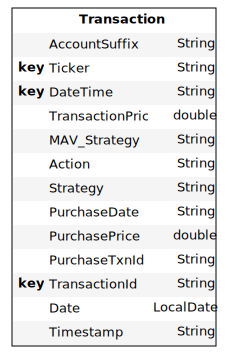

In [4]:
cube = session.cubes["TxnCube"]
cube.schema

## 2. Setting the stage

Before we see how bucketing is being used in our analysis, let's set up some orders for our data and create the measures that we want to look at.

In [5]:
h, l, m = cube.hierarchies, cube.levels, cube.measures

### 2.1. Ordering timeseries  

Since we are unsure if the data loaded is ordered in the way we want, we can enforce the order we want.

There are two ways to perform [ordering](https://docs.atoti.io/latest/lib/atoti/atoti.order.html) on members of a level:
1. [`NaturalOrder`](https://docs.atoti.io/latest/lib/atoti/atoti.order.natural_order.html) for ascending/descending order
2. [`CustomOrder`](https://docs.atoti.io/latest/lib/atoti/atoti.order.custom_order.html) based on a given ordered list for the first number of elements  

We set our timeseries on ascending order.

In [6]:
l["Date"].order = tt.NaturalOrder()
l["DateTime"].order = tt.NaturalOrder()
l["Timestamp"].order = tt.NaturalOrder()

### 2.2. Computing key performance metrics  

In this use case, we will focus on the realized PnL for the accounts along the time series.  
Given our data model, the realized PnL can be computed simply by:

$$ RealizedPnL = TransactionPrice - PurchasePrice $$

In order to focus only on the metrics that we want, we have created the cube in the `no_measures` mode. This means that other than the `contributors.COUNT`, no other measures are created. We will see in the subsequent sections how we create these measures.  

Refer to [`atoti.agg`](https://docs.atoti.io/latest/lib/atoti/atoti.agg.html) package for the available aggregation function in Atoti. 

#### 2.2.1. Creating measures from table

We can apply aggregation functions on a table column as shown below. 

In [7]:
txn_tbl = session.tables["Transaction"]

m["PurchasePrice.SUM"] = tt.agg.sum(txn_tbl["PurchasePrice"])
m["TransactionPrice.SUM"] = tt.agg.sum(txn_tbl["TransactionPrice"])

m["PurchasePrice"] = tt.agg.single_value(txn_tbl["PurchasePrice"])
m["TransactionPrice"] = tt.agg.single_value(txn_tbl["TransactionPrice"])

`PurchasePrice.SUM` and `TransactionPrice.SUM` are the equivalent of what the cube would have created automatically.  
Instead of summing up the purchase price and transaction price, we use `single_value` to return only the unique values. We can see at the `TransactionId` level, the `PurchasePrice` varies for different transactions. Therefore, no value is returned on the top level.  

In [8]:
session.visualize("AAPL transactions on 2023-03-15")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

#### 2.2.2. Compute realized PnL  

PnL is realized once the ticker is sold. Therefore, we can simply take the difference between the purchase price and transaction price when the transaction action is "Sell". This difference is performed at the `TransactionId` level, hence, we add it in the scope.

In addition, since we have a [conditional check](https://docs.atoti.io/latest/lib/atoti/atoti.function.where.html) on the `Action`, it has to be included in the scope as well.  

In [9]:
m["RealizedPnL"] = tt.agg.sum(
    tt.where(l["Action"] == "Sell", m["TransactionPrice"] - m["PurchasePrice"]),
    scope=tt.OriginScope(l["TransactionId"], l["Action"]),
)

#### 2.2.3. Cumulate realized PnL

We can cumulate the realized PnL along different levels, e.g. Date, DateTime and Timestamp.  
Remember to use the correct measure when querying along the different levels. 

In [10]:
m[f"Cum_Date_RealizedPnL"] = tt.agg.sum(
    m["RealizedPnL"], scope=tt.CumulativeScope(level=l["Date"])
)

m[f"Cum_DateTime_RealizedPnL"] = tt.agg.sum(
    m["RealizedPnL"], scope=tt.CumulativeScope(level=l["DateTime"])
)

m[f"Cum_Timestamp_RealizedPnL"] = tt.agg.sum(
    m["RealizedPnL"], scope=tt.CumulativeScope(level=l["Timestamp"])
)

In [11]:
session.visualize("Realized PnL by accounts on 2023-03-15")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

Using subplot to visualize the PnL trend for each account, we can clearly see that ACCT3 was making a loss for most part of the day.  
Let's dive a little more into the account to understand the loss better.

In [12]:
session.visualize("Realized PnL for Account 3 on 2023-03-15 by MAV strategies")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

We can see that the sales of BRK-B is causing most of the loss.  
Also, the strategy MAV_close_15 and MAV_close_30 are not performing well for NVDA.  

The strategies are simply different ways that the moving average is applied to obtain the buying and selling signals. These data are the outputs from our simplified trading algorithms and you can do the same with your own algorithms.

## 3. Creating buckets

### 3.1. Date bucketing

Out-of-the-box, we are able to create [date buckets](https://docs.atoti.io/latest/lib/atoti/atoti.cube.html#atoti.Cube.create_date_hierarchy) that allow us to visualize data by different buckets such as yearly, quarterly, monthly etc.  
This way, we need not split our date column into the various buckets, saving physical data space.


In [13]:
cube.create_date_hierarchy(
    "Date hierarchy",
    column=txn_tbl["Date"],
    levels={"Year": "yyyy", "Quarter": "QQQ", "Month": "MM", "Day": "dd"},
)

The date buckets allow us to drill down on the period where performance is not ideal and see what are the contributing factors.

ACCT4 has the lowest realized revenue compare to the other accounts. We made a loss in February. Drilling down to the day level, we can see that we made the most loss on 2023-02-13 on AMZN. Similarly, sorting on GOOGL will show that we made the most loss for the stock on 2023-02-15.  

In [14]:
session.visualize("Bucketed realized PnL")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

### 3.2. Time bucketing

We can enrich the cube with other data sources. Tables can be joined to the base table before or after cube creation.  
This allow us to inject new dimensions to the cube as we draw new insights or inspirations.  

We generated a CSV containing bucket mapping to the trading hours of the stocks, with granularity up to the minutes.  
By joining the time bucket data to the base table, we can now view our data by our predefined buckets.

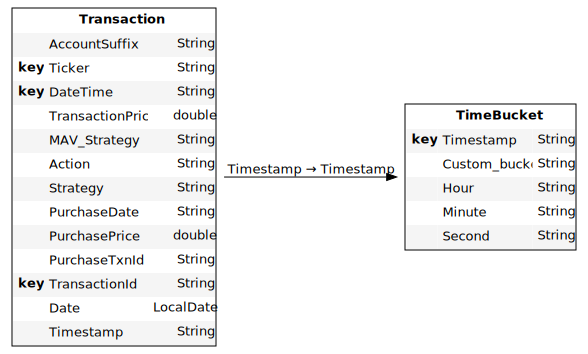

In [15]:
time_tbl = session.read_csv(
    "s3://data.atoti.io/notebooks/bucket-exploration/time_bucket.csv",
    table_name="TimeBucket",
    keys=["Timestamp"],
    types={
        "Timestamp": tt.type.STRING,
        "Hour": tt.type.STRING,
        "Minute": tt.type.STRING,
        "Second": tt.type.STRING,
    },
)

txn_tbl.join(time_tbl, txn_tbl["Timestamp"] == time_tbl["Timestamp"])
cube.schema

In [16]:
m[f"Cum_Custom_RealizedPnL"] = tt.agg.sum(
    m["RealizedPnL"], scope=tt.CumulativeScope(level=l["Custom_bucket"])
)

In [17]:
session.visualize("Number of transactions by custom time buckets")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

In the function below, we enriched our cube with more tables to be able to understand our data from different perspectives.

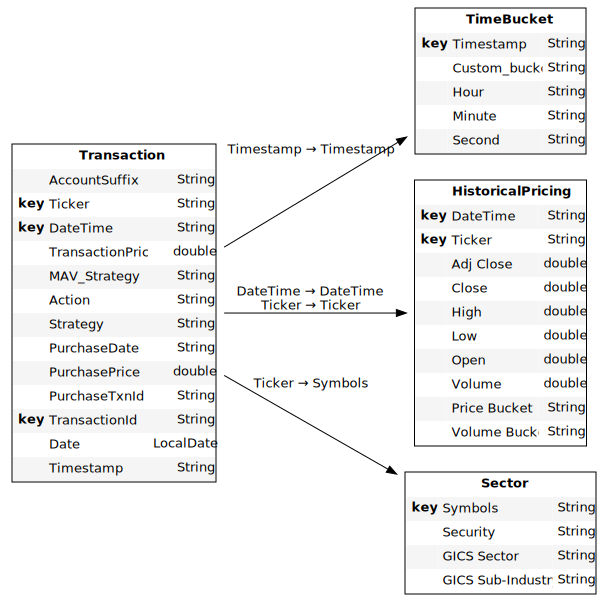

In [18]:
data_model.enrich_cube(session)
data_model.create_measures(session)

cube.schema

In [19]:
session.visualize("Realized PnL by price buckets")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

## 4. Loading additional transactions

Once we have our data model established, we can upload the transactions of different strategies incrementally to the cube without having to restart.  
This makes it convenient for us to keep our train of thoughts without having to go back to the code base again.  

Below, we demonstrate how we can have interactive data loading in the notebook using [ipywidgets](https://ipywidgets.readthedocs.io/en/stable/).

In [20]:
from ipywidgets import FileUpload, Output, FloatProgress
from IPython.display import display
import pandas as pd
import io

In [21]:
out = Output()
fp = FloatProgress(min=0, max=2)

In [22]:
@out.capture()
def on_upload_change(change):
    out.clear_output()
    display(fp)
    print("Uploading file for", change["new"][0].name)

    fp.value = 0
    print("- Reading file")
    input_file = list(change["new"])[0]
    content = input_file["content"]
    df = pd.read_csv(io.BytesIO(content))

    # Atoti inherits the data type from Pandas DataFrame.
    # Hence, we cast the data type before loading into the table.
    df[["DateTime", "PurchaseDate", "Timestamp"]] = df[
        ["DateTime", "PurchaseDate", "Timestamp"]
    ].astype(str)
    df["Date"] = pd.to_datetime(df["Date"]).dt.date

    print("data type of file loaded:")
    print(df.dtypes)

    fp.value = 1

    print("-- loading into transaction table")
    data_model.load_transactions(session, df)
    fp.value = 2

    displayFileLoader()

In [23]:
def displayFileLoader():
    uploader = widgets.FileUpload(
        accept=".csv",
        multiple=False,
    )

    uploader.observe(on_upload_change, "value")
    with out:
        display(uploader)

We will be able to load new transaction data for the cube as long as it follows the same columns and their data types.  
Download this [sample transaction file](https://data.atoti.io/notebooks/bucket-exploration/transactions_c.csv) and try loading it with the below function.

In [24]:
displayFileLoader()
out

Output()

We are now able to access the latest data!  

If you are loading the [sample transaction file](https://data.atoti.io/notebooks/bucket-exploration/transactions_c.csv) provided, switch the below cell to code and run it to see the difference between the two strategy.

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=buckets" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/discover-try.png" alt="Try atoti"></a></div>